# 5.0-scRepertoire in Tumor T0

**Inés Sentís**

Date of execution 

In [1]:
Sys.Date()

[1] "2025-01-27"

## Introduction

Use [scRepertoire](https://www.borch.dev/uploads/vignette/vignette) to explore clonotypes

## Libraries

In [2]:
options(warn = -1, verbose = FALSE)
suppressMessages(suppressWarnings({
library(Seurat)
library(scRepertoire)
library(here)
library(glue)
library(tidyverse)
library(ggplot2)
library(dplyr)
}))

## Parameters

In [3]:
#dr_here(show_reason = TRUE)
source(here("utils/bin.R"))
source(here("utils/style.R"))

set.seed(0)

`mode` = "gene", "nt", "aa", "strict" (same as scRepetoire)

`chain` = "both", "TRB" (use both alpha and beta chains to call clones or just the beta one )

In [4]:
# depending on clone call
mode = "nt" 
chain = "TRB"

## Load data

### Load PBMC Timepoint repertoires

In [5]:
source(here("SCGRES_83_120/misc/paths.R"))
pbmc <- readRDS(here(glue("{tcr}/{robj_dir}/5.0-pbmcTCR_{mode}_{chain}.rds")))
cluster_names <- levels(pbmc)
pbmc@meta.data$cdr3 <- substr(pbmc@meta.data$CTnt, start = 3 + 1, stop = nchar(pbmc@meta.data$CTnt) - 3)

### Load seurat object with Tumor cells

In [6]:
source(here("SCGRES_99_100/sc_analysis/misc/paths.R"))
seurat_obj <- readRDS(here(glue("{annot}/{robj_dir}/4.2-subset_tcell.rds")))

In [7]:
lvl ="Tcell_clusters"
cd8_clusters <- c("0","1","3","4","8","10")

### Load TCR data from Tumor samples

In [8]:
metadata <- read.csv(here(glue("{cellranger}/metadata.csv")))

In [9]:
metadata <- subset(metadata, type == "VDJ-T" & timepoint == "T0")

In [10]:
list_contigs <- lapply(unique(metadata$gem_id),function(lib) {
    
    sample <- gsub("CC2269", "",lib)
    sample <- gsub("_1", "",sample)
    print(sample)
    
    data <- read_csv(here(glue("{cellranger}/jobs/{lib}/{lib}/outs/per_sample_outs/{lib}/vdj_t/filtered_contig_annotations.csv")))
    data$timepoint <- "T0"
    data$replicate <- "1"
    data$sample_id <- paste("T0", sample)
    data$sample_org <- lib
    data
})

[1] "CD45pos"


Rows: 6548 Columns: 31
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (23): barcode, contig_id, chain, v_gene, d_gene, j_gene, c_gene, fwr1, f...
dbl  (4): length, reads, umis, exact_subclonotype_id
lgl  (4): is_cell, high_confidence, full_length, productive

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "CD3pos"


Rows: 20174 Columns: 31
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (23): barcode, contig_id, chain, v_gene, d_gene, j_gene, c_gene, fwr1, f...
dbl  (4): length, reads, umis, exact_subclonotype_id
lgl  (4): is_cell, high_confidence, full_length, productive

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [11]:
list_names <- lapply(list_contigs, function(data) {
   gsub(" ", "_", unique(data$sample_id))
})
list_names

[[1]]
[1] "T0_CD45pos"

[[2]]
[1] "T0_CD3pos"

## Combine and add contigs in Tumor

In [12]:
combined <- combineTCR(list_contigs,
                 samples = list_names,
                 filterMulti = TRUE)

In [13]:
source(here("SCGRES_83_120/misc/paths.R"))
saveRDS(combined, here(glue("{tcr}/{robj_dir}/5.0-combinedTCR.rds")))

In [14]:
# modify reprtoire dataframe for simplicity
if (chain == "TRB") {
    if (mode == "strict") {
        combined <- lapply(names(combined), function(rep) {
            
            df <- combined[[rep]]
            df$TRB <- str_split(df$CTgene, "_", simplify = TRUE)[, 2]
            df$vj <-  sub(".[^.]+$", "",df$TRB) 
            #remove D also
            df <- df %>%
                mutate(vj = sapply(vj, split_and_rejoin, separator = "[.]"))
            df$seq <- str_split(df$CTnt, "_", simplify = TRUE)[, 2]
            df <- df %>% 
                mutate(CTstrict = ifelse(is.na(vj) & is.na(seq), NA, paste(vj, seq, sep = "_")))
            df <- df[df[["CTstrict"]] != "NA_NA",]
            df
        })
    } else {
         combined <- lapply(names(combined), function(rep) {
            df <- combined[[rep]]
            df$CTgene <- str_split(df$CTgene, "_", simplify = TRUE)[, 2]
            df$CTnt <- str_split(df$CTnt, "_", simplify = TRUE)[, 2]
            df$CTaa <- str_split(df$CTaa, "_", simplify = TRUE)[, 2]
            df <- df[df[["CTgene"]] != "NA",]
            df <- df[df[["CTnt"]] != "NA",]
            df <- df[df[["CTaa"]] != "NA",]
            })
    } 
    combined <- setNames(combined, list_names)
}

In [15]:
seurat_tcr <- combineExpression(combined, seurat_obj, 
                  cloneCall = mode,        
                  proportion = FALSE, 
                  cloneTypes=c(Single=1, Small=5, Medium=10, Large=20, Hyperexpanded=200))

In [16]:
colorblind_vector <- colorRampPalette(rev(c("#0D0887FF", "#47039FFF", 
              "#7301A8FF", "#9C179EFF", "#BD3786FF", "#D8576BFF",
              "#ED7953FF","#FA9E3BFF", "#FDC926FF", "#F0F921FF")))

In [17]:
table(seurat_tcr$cloneType)


Hyperexpanded (20 < X <= 200)          Large (10 < X <= 20) 
                         1424                          1061 
         Medium (5 < X <= 10)           Single (0 < X <= 1) 
                         1412                          4757 
           Small (1 < X <= 5) 
                         3310 

In [18]:
slot(seurat_tcr, "meta.data")$cloneType <- factor(slot(seurat_tcr, "meta.data")$cloneType, 
                levels = c("Hyperexpanded (20 < X <= 200)", 
                           "Large (10 < X <= 20)", 
                           "Medium (5 < X <= 10)", 
                           "Small (1 < X <= 5)", 
                           "Single (0 < X <= 1)", NA))
p_clono <- DimPlot(seurat_tcr, group.by = "cloneType",pt.size = 0.6) +
  labs(title=glue("Expansion level")) + theme(plot.title = element_text(hjust = 0.5)) +
    scale_color_manual(values = colorblind_vector(5), na.value="grey")

In [19]:
p_clust <- DimPlot(seurat_tcr, reduction = "umap",
                   cols=tumor_pal)+ 
  labs(title=glue("T-cell clusters")) + theme(plot.title = element_text(hjust = 0.5))

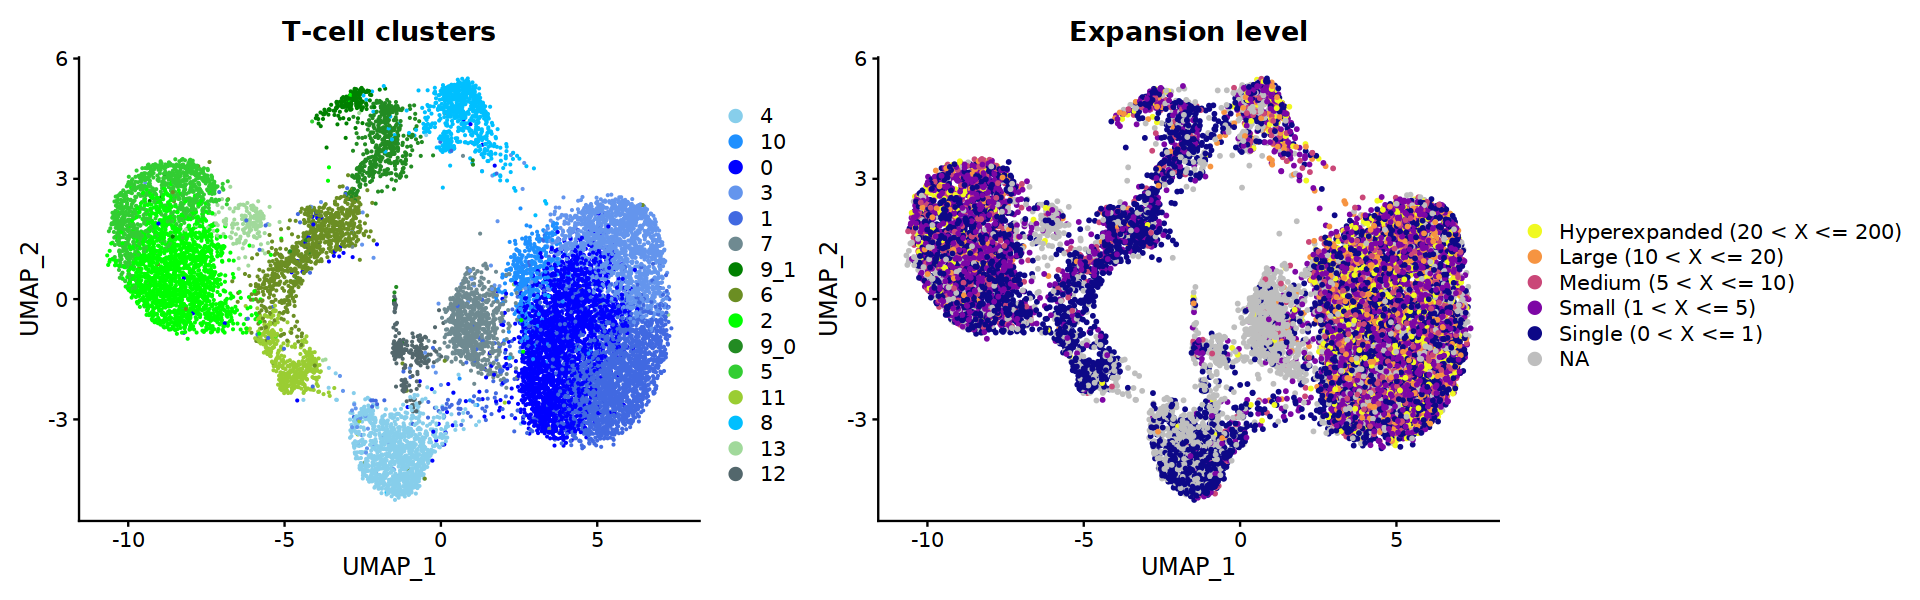

In [20]:
options(repr.plot.width = 16, repr.plot.height = 5, warn=-1,verbose = FALSE)
p_clust + p_clono

In [21]:
ggsave(plot = p_clono,width = 9, height = 6, dpi = 300, 
       file = here::here(glue::glue("{tcr}/{plt_dir}/5.0-tumorUMAP_expansions.svg")))

Consider only CDR3 Bchain region

In [22]:
seurat_tcr@meta.data$cdr3 <- substr(seurat_tcr@meta.data$CTnt, start = 3 + 1, stop = nchar(seurat_tcr@meta.data$CTnt) - 3)
col_name <- "cdr3"

In [23]:
df_summary <- seurat_tcr@meta.data %>%
  filter(!is.na(!!as.name(col_name))) %>%
  group_by(!!as.name(col_name)) %>%
  summarise(
    sample_id = list(unique(sample_id)),
    count = n()
  ) %>%
  filter(count > 1) %>%
  arrange(desc(count)) 

head(df_summary, n=20)

cdr3,sample_id,count
<chr>,<list>,<int>
AGTGCGGGACTAGCGGGGCTGGGTCCGCGGGAGCAGTAC,"T0_CD3pos , T0_CD45pos",177
GCCAGCAGCGAGAACGGACAGGGATCCTACAATGAGCAGTTC,"T0_CD3pos , T0_CD45pos",116
GCCAGCAGCGGGCAGAAAAACATTCAGTAC,"T0_CD3pos , T0_CD45pos",90
GCCAGCAGCTGGACAGCTCAAGCTTTC,"T0_CD3pos , T0_CD45pos",88
GCCAGCAGCGGGGGGACGGAGATGAACACTGAAGCTTTC,"T0_CD3pos , T0_CD45pos",84
GCCATCAGTGTTGTTCCCGGGTTCCCCTTCTACGAGCAGTAC,"T0_CD3pos , T0_CD45pos",84
GCCAGCAGCCAAGACCCGGGACTAGAGTACTACAATGAGCAGTTC,"T0_CD3pos , T0_CD45pos",67
GCCAGCAGTGAAGCTGGGGAAATATGGTATTCACCCCTCCAC,"T0_CD3pos , T0_CD45pos",67
GCCAGTAGTACAGGGGTGAACACTGAAGCTTTC,"T0_CD3pos , T0_CD45pos",61


## Clonotype size per cluster

Join S4 to cluster 8 since both are proliferative cd8 por de visualization of the barplots

In [24]:
df_tmp <- seurat_tcr@meta.data %>%
    mutate(!!as.name(lvl) := if_else(subclustering == "S4", "8", !!as.name(lvl))) %>%
    group_by(!!as.name(lvl), !!as.name(col_name)) %>%
    summarise(
        count = n()) %>% 
    dplyr::filter(!!as.name(lvl) %in% cd8_clusters) %>%
    dplyr::filter(!is.na(cdr3)) %>%
    dplyr::filter(count!=1) %>%
    mutate(category = case_when(count > 20  ~ "X > 20",
                                count > 10 & count <= 20 ~ "10 < X <= 20",
                                count > 5 & count <= 10 ~ "5 < X <= 10",
                                count > 1 & count <= 5 ~ "1 < X <= 5")) %>%
    arrange(desc(count))

In [25]:
df_plot2 <- df_tmp %>%
  group_by(!!as.name(lvl), category) %>%
  summarise(count = n())

In [26]:
df_plot2$category <- factor(df_plot2$category, levels = rev(c("1 < X <= 5", "5 < X <= 10", 
                                                              "10 < X <= 20", "X > 20")))
df_plot2$Tcell_clusters <- factor(df_plot2$Tcell_clusters, levels = rev(c("0", "1", "3", 
                                                                          "8", "10", "4")))

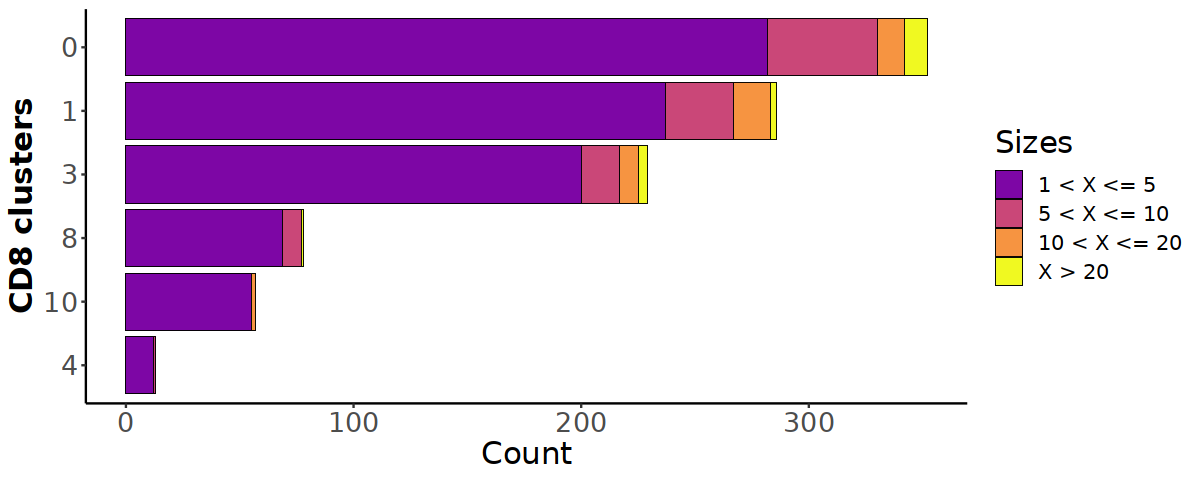

In [27]:
options(repr.plot.width = 10, repr.plot.height = 4, warn=-1,verbose = FALSE)
bp <- barplot_clonotypes(df_plot2, lvl, "CD8 clusters") 
bp

In [28]:
ggsave(plot = bp, width = 10, height = 4, dpi = 300, 
       file = here::here(glue::glue("{tcr}/{plt_dir}/5.0-CD8_clono_size.svg")))

In [29]:
df_tmp <- seurat_tcr@meta.data %>% 
    group_by(!!as.name(lvl), !!as.name(col_name)) %>%
    summarise(
        count = n()) %>% 
    dplyr::filter(!!as.name(lvl) %in% c("2","5","13")) %>%
    dplyr::filter(!is.na(cdr3)) %>%
    dplyr::filter(count!=1) %>%
    mutate(category = case_when(count > 20  ~ "X > 20",
                                count > 10 & count <= 20 ~ "10 < X <= 20",
                                count > 5 & count <= 10 ~ "5 < X <= 10",
                                count > 1 & count <= 5 ~ "1 < X <= 5")) %>%
    arrange(desc(count))

In [30]:
df_plot2 <- df_tmp %>%
  group_by(!!as.name(lvl), category) %>%
  summarise(count = n())

In [31]:
df_plot2$category <- factor(df_plot2$category, levels = rev(c("1 < X <= 5", "5 < X <= 10", 
                                                              "10 < X <= 20", "X > 20")))
df_plot2$Tcell_clusters <- factor(df_plot2$Tcell_clusters, levels = rev(c("2","5","13")))

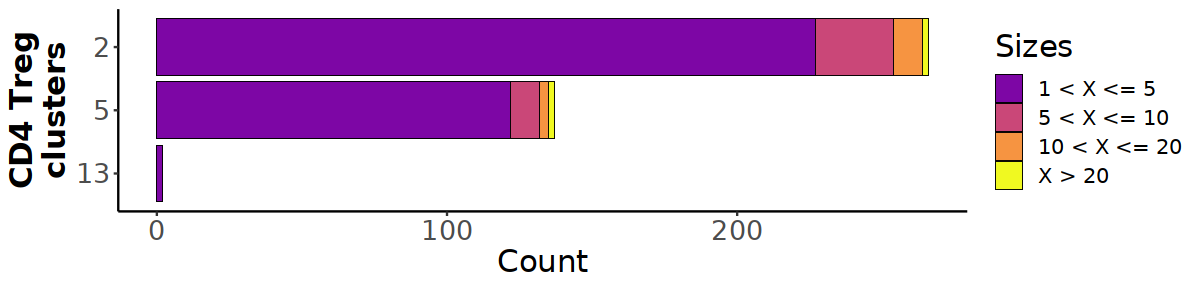

In [32]:
options(repr.plot.width = 10, repr.plot.height = 2.4, warn=-1,verbose = FALSE)
bp <- barplot_clonotypes(df_plot2, lvl, "CD4 Treg\nclusters")
bp

In [33]:
ggsave(plot = bp, width = 10, height = 2.4, dpi = 300, 
       file = here::here(glue::glue("{tcr}/{plt_dir}/5.0-CD4Tregs_clono_size.svg")))

## Save

In [34]:
source(here("SCGRES_83_120/misc/paths.R"))
saveRDS(seurat_tcr, here(glue("{tcr}/{robj_dir}/5.0-tumorTCR_{mode}_{chain}.rds")))

## Session Info

In [35]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] lubridate_1.9.3     forcats_1.0.0       stringr_1.5.0      
 [4] dplyr_1.1.3         purrr_1.0.2         readr_2.1.4        
 [7] tidyr_1.3.0         tibble_3.2.1        tidyverse_2.0.0    
[10] glue_1.6.2          here_1.0.1          scRepertoire_1.12.0
[13] ggplot2_3.4.4   